In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

In [3]:
# Random set kernel
# from modelval.kernel import KernelGen
# plt.figure(figsize=(5,3))
# ker_test = KernelGen()
# ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=5, scale=0.1, shift=-1)
# ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=7, scale=0.15)
# ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=10, scale=0.5, shift=-1)
# plt.plot(ker_test.kernel_pre, label='ker_pre')
# plt.plot(ker_test.kernel_post, label='ker_post')
# plt.plot(ker_test.kernel_post_post, label='ker_post_post')
# plt.legend()

1.0 1.0 1.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


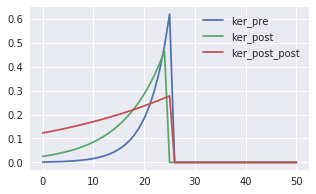

In [4]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Visu_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms
tau_post_post = tau[3]/reso_set # ms

ker_test.kernel_pre = KernelGen().uni_exp_ker(side='left', tau=tau_pre_post, scale=1, shift=-1)
ker_pre_norm = np.linalg.norm(ker_test.kernel_pre, ord=2)
ker_test.kernel_pre = ker_test.kernel_pre/ker_pre_norm
ker_test.kernel_post = KernelGen().uni_exp_ker(side='left', tau=tau_post_pre, scale=1)
ker_post_norm = np.linalg.norm(ker_test.kernel_post, ord=2)
ker_test.kernel_post = ker_test.kernel_post/ker_post_norm
ker_test.kernel_post_post = KernelGen().uni_exp_ker(side='left', tau=tau_post_post, scale=1, shift=-1)
ker_post_post_norm = np.linalg.norm(ker_test.kernel_post_post, ord=2)
ker_test.kernel_post_post = ker_test.kernel_post_post/ker_post_post_norm
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2))

In [5]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [6]:
# Drop long protocl that can be replaced by STDP
data.drop(data[data['ptl_occ'] == 50].index, axis=0, inplace=True)

In [7]:
data[data['ptl_idx'] == 5]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
144,5,5,10,5,10,15,0.1,10.0,0.0,0,115.724663,9.195363,150.0
145,5,5,20,5,20,15,0.1,10.0,0.0,0,131.265503,12.873509,150.0
146,5,5,40,5,40,15,0.1,10.0,0.0,0,154.160944,10.114900,150.0
147,5,5,50,5,50,15,0.1,10.0,0.0,0,156.368508,25.747018,150.0


In [8]:
# Generate data
ptl_list = [1,5,6,7,8]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data_select[data_select['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)

# for i in range(len(dt)):
#     if np.abs(dt[i])>10:
#         new_try2 = data_select[data_select['ptl_idx']==3].iloc[0]
#         new_try2['dt2'] = dt[i]
#         data_select = data_select.append(new_try2, ignore_index=True)
    
kernel_scale = np.array([a[0]*ker_pre_norm, a[2]*ker_post_norm, a[3]*ker_post_post_norm])
# kernel_scale = np.array([a[0]*ker_pre_norm, a[2]*ker_post_norm, 0])

spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data_select, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, kernel_scale=kernel_scale, aug_times=[5,20,20,20,20], net_type='triplet')

In [9]:
spk_pairs.shape

(1105, 75000, 2)

In [15]:
# Create the network
ground_truth_init = 0
reg_scale = (0,1)
toy_data_net2 = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, kernel_scale=kernel_scale, reg_scale=reg_scale, n_input=spk_pairs.shape[1])

In [16]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/TripNet_ptl1_toy'
toy_net2_trainer = trainer.Trainer(toy_data_net2.mse, toy_data_net2.loss,input_name=toy_data_net2.inputs, target_name=toy_data_net2.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net2.lr})

In [17]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

array([-0.22614121, -0.27994752,  0.95375919], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


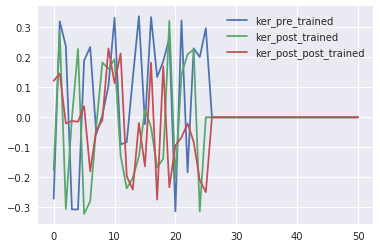

In [18]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
w_post_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post_post)
fc_w = toy_net2_trainer.evaluate(ops=toy_data_net2.fc_w)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()
fc_w

In [ ]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net2_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net2.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 16150 and Step 0007: validation cost=0.00003
Global Step 16200 and Step 0057: validation cost=0.00003
Global Step 16250 and Step 0107: validation cost=0.00002
Updated min validation loss!Saving model...
Global Step 16300 and Step 0157: validation cost=0.00002
Updated min validation loss!Saving model...
Global Step 16350 and Step 0207: validation cost=0.00003
Global Step 16400 and Step 0257: validation cost=0.00002
Updated min validation loss!Saving model...


array([ 0.00031328,  0.01488998,  0.0306496 ], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


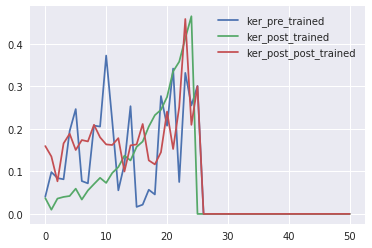

In [20]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
w_post_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post_post)
fc_w = toy_net2_trainer.evaluate(ops=toy_data_net2.fc_w)
plt.plot(np.abs(w_pre),  label='ker_pre_trained')
plt.plot(np.abs(w_post),  label='ker_post_trained')
plt.plot(np.abs(w_post_post), label='ker_post_post_trained')
plt.legend()
np.abs(fc_w)

In [36]:
kernel_scale

array([ 0.00983431,  0.00344618,  2.15023217])